In [1]:
print("Welcome to Machine Learning")

Welcome to Machine Learning


In [2]:
import sys 
sys.version_info >= (3,10)
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

In [3]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets", filter="data")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing_full = load_housing_data()

In [4]:
housing_full.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing_full.index

RangeIndex(start=0, stop=20640, step=1)

In [7]:
housing_full["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [8]:
housing_full.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


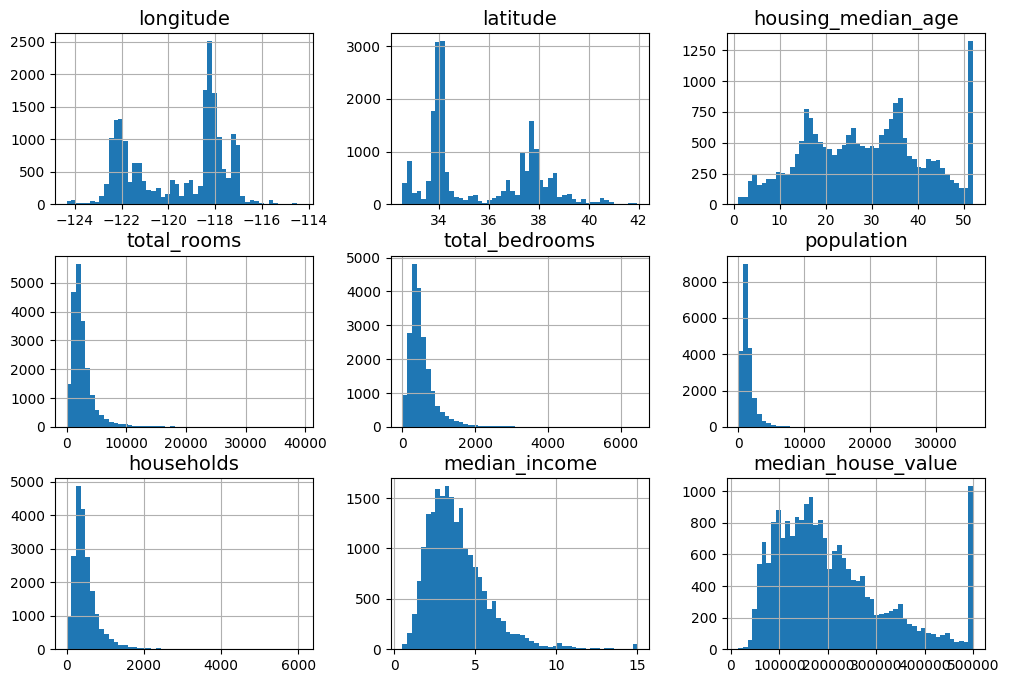

In [9]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
housing_full.hist(bins=50, figsize=(12,8))
plt.show()

In [10]:
#Daten für das Testen und Trainieren trennen!
def shuffle_and_split_data(data, test_ratio, rng):
    shuffled_indices = rng.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
#Nimm 20 % der Daten für die spätere Prüfung (Test) und 80 % zum Lernen (Training)
rng = np.random.default_rng(seed=42)
train_set, test_set = shuffle_and_split_data(housing_full, 0.2, rng)
#Daten für das Training
len(train_set)

16512

In [12]:
#Daten für den Test
len(test_set)

4128

In [13]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_ : is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
housing_with_id = housing_full.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [15]:
housing_with_id["id"] = (housing_full["longitude"] * 1000
                         + housing_full["latitude"])
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [16]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing_full, test_size=0.2, random_state=42)

In [17]:
test_set["total_bedrooms"].isnull().sum()

np.int64(44)

In [18]:
from scipy.stats import binom
sample_size = 1000
ratio_female = 0.516
proba_too_small = binom(sample_size, ratio_female).cdf(490 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(540)
print(proba_too_small + proba_too_large)

0.10727422667455677


In [19]:
housing_full["income_cat"] = pd.cut(housing_full["median_income"], 
                                    bins = [0, 1.5, 3.0, 4.5, 6.0, np.inf],
                                    labels = [1, 2, 3, 4, 5])

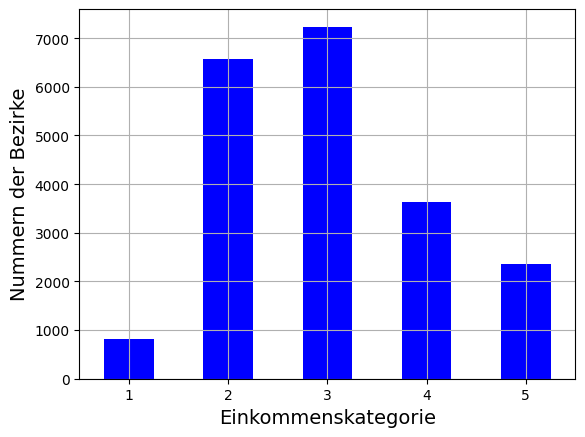

In [20]:
cat_counts = housing_full["income_cat"].value_counts().sort_index()
cat_counts.plot.bar(rot=0, grid=True, color="blue")
plt.xlabel("Einkommenskategorie")
plt.ylabel("Nummern der Bezirke")
plt.show()

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing_full, 
                                              housing_full["income_cat"]):
    strat_train_set_n = housing_full.iloc[train_index]
    strat_test_set_n = housing_full.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [22]:
strat_train_set, strat_test_set = strat_splits[0]

In [23]:
strat_train_set, strat_test_set = train_test_split(
    housing_full, test_size=0.2, stratify=housing_full["income_cat"],
    random_state=42)

In [24]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [25]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing_full, test_size=0.2,
                                       random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing_full),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [26]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True, errors="ignore")

In [27]:
housing = strat_train_set.copy()

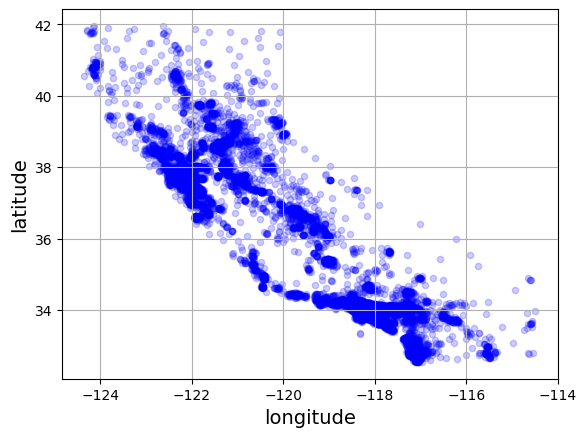

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, color="blue", alpha=0.2)
plt.show()

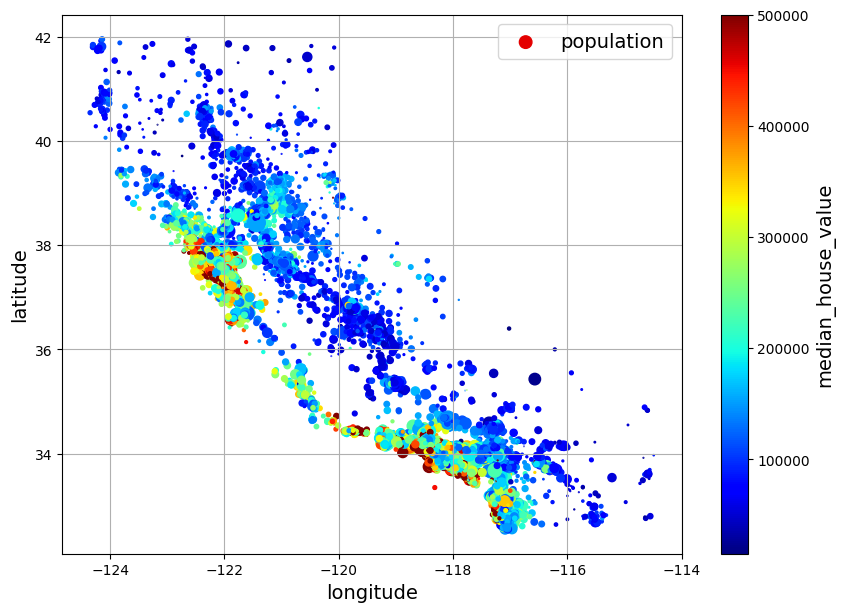

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

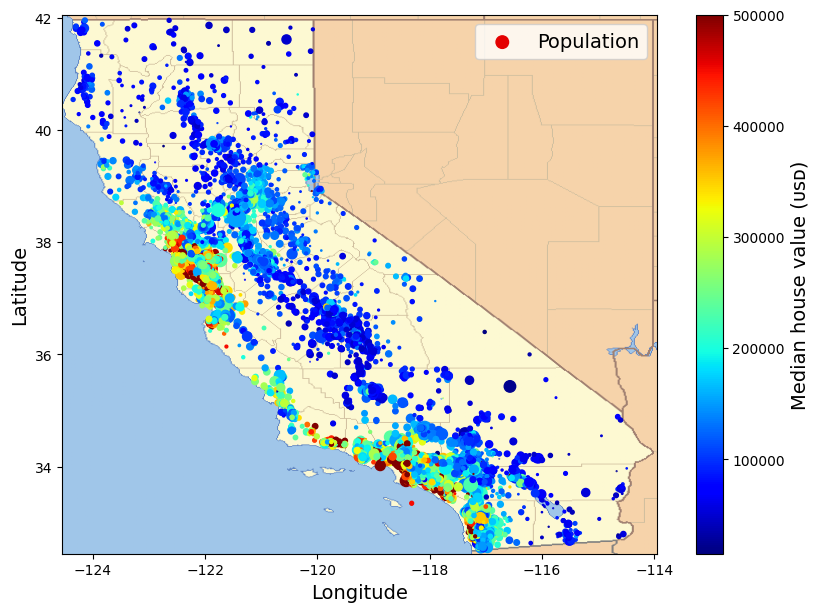

In [30]:
# extra code – this cell generates the first figure in the chapter

# Download the California image
filename = "california.png"
filepath = Path(f"my_{filename}")
if not filepath.is_file():
    homlp_root = "https://github.com/ageron/handson-mlp/raw/main/"
    url = homlp_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, filepath)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(filepath)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

plt.show()

In [31]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN


In [32]:
corr_matrix = housing.corr(numeric_only=True)

In [33]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

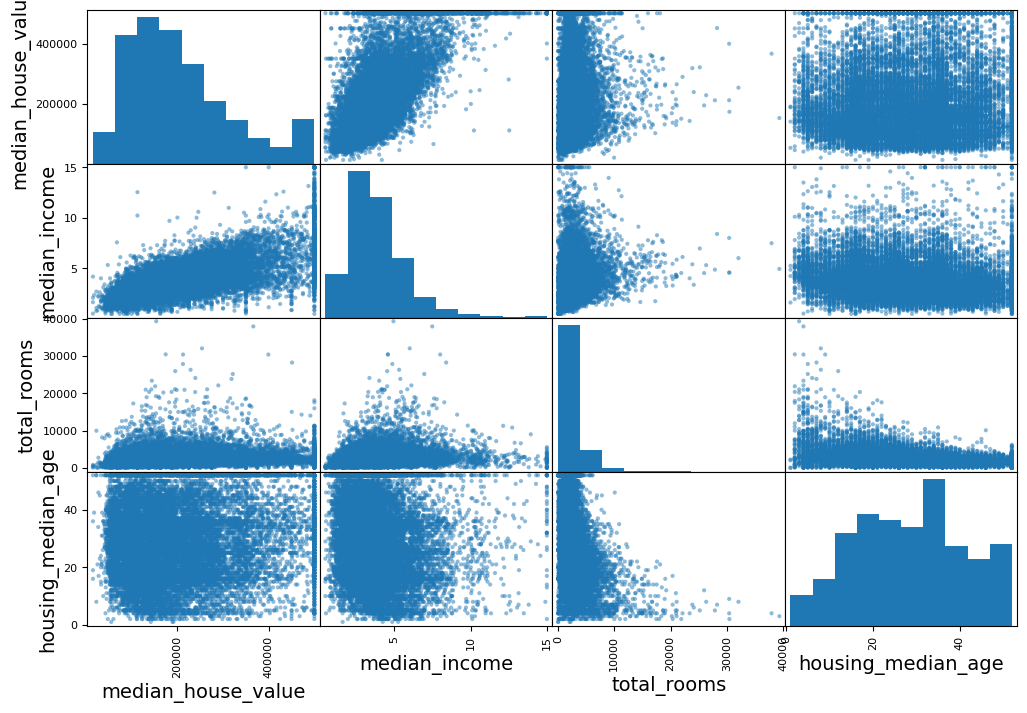

In [34]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

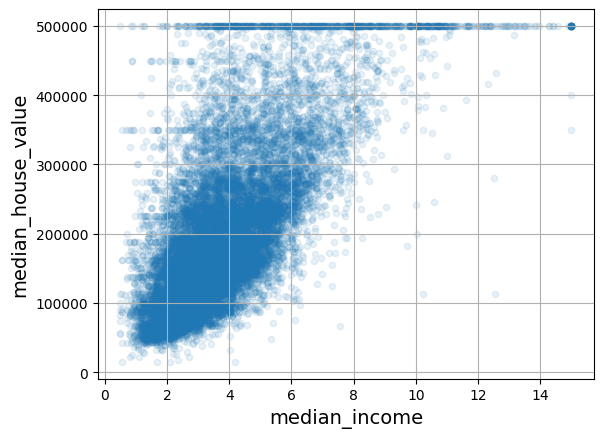

In [35]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)

In [36]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN


In [37]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedroom_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [38]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedroom_ratio        -0.256397
Name: median_house_value, dtype: float64

In [39]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [40]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"] = housing["total_bedrooms"].fillna(median)

In [41]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [42]:
print(imputer.statistics_)
housing_num.median().values

[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [43]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, 
                          index=housing_num.index)

In [44]:
imputer.strategy

'median'

In [45]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [46]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1], shape=(16512,))

In [47]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [48]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [49]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [50]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [51]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [52]:
#Alternativ
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [53]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [54]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [55]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [56]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN",
                                                    "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [57]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [58]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [59]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [60]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [61]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [62]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [63]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]],
                          [[35]], gamma=0.1)

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]],
          scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]


scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [65]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]],
          housing_labels)
predictions = model.predict(some_new_data)

In [66]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [67]:
rbf_transformer = FunctionTransformer(rbf_kernel, 
                                      kw_args = dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [68]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [69]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:,[1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [70]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean:True):
        self.with_mean = with_mean

    def fit(self, X, y=None):
        X = check_array(X)
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_feature_in_ = X.shape[1]
        return self
    
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_feature_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
            return X / self.scale_

In [71]:

from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


In [72]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]])

In [73]:
similarities[:3].round(2)

array([[0.46, 0.  , 0.08, 0.  , 0.  , 0.  , 0.  , 0.98, 0.  , 0.  ],
       [0.  , 0.96, 0.  , 0.03, 0.04, 0.  , 0.  , 0.  , 0.11, 0.35],
       [0.34, 0.  , 0.45, 0.  , 0.  , 0.  , 0.01, 0.73, 0.  , 0.  ]])

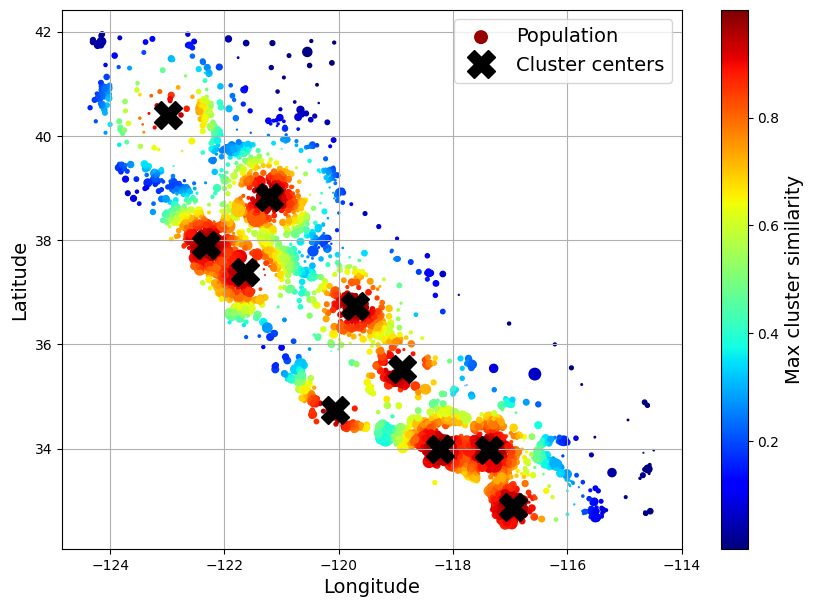

In [74]:
# extra code – this cell generates Figure 2–19

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")

plt.show()

In [75]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute",
     SimpleImputer(strategy="median")),
     ("standardize", StandardScaler),
])

In [76]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [77]:
from sklearn import set_config

set_config(display="diagram")


In [78]:
num_pipeline

,steps,"[('simpleimputer', ...), ('standardscaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [79]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [80]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

In [81]:
df_housing_num_prepared.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942


In [82]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, 
    columns=num_pipeline.get_feature_names_out(), # Holt die Namen wie "Latitude", "Income"
    index=housing_num.index # Behält die ursprünglichen ID-Nummern der Zeilen
)

In [83]:
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041
13105,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630
19301,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049
19121,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396


In [84]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [85]:
num_pipeline[1]

,copy,True
,with_mean,True
,with_std,True


In [86]:
num_pipeline[:-1]

,steps,"[('simpleimputer', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [87]:
num_pipeline.named_steps["simpleimputer"]

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [88]:
num_pipeline.set_params(simpleimputer__strategy="median")

,steps,"[('simpleimputer', ...), ('standardscaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [89]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", 
               "housing_median_age", "total_rooms", 
               "total_bedrooms", "population", "households", 
               "median_income"]
cat_attribs = ["ocean_proximity"]


cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [90]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [91]:
housing_prepared = preprocessing.fit_transform(housing)

In [92]:
housing_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41803793,  0.94797769,  1.22545939, ...,  0.        ,
         0.        ,  1.        ]], shape=(16512, 13))

In [93]:
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


In [94]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.neighbors import NearestNeighbors

# =========================
# 1️⃣ Ratio-Pipeline
# =========================
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

# =========================
# 2️⃣ Log-Pipeline
# =========================
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

# =========================
# 3️⃣ KNN-Geo-Transformer
# =========================
class KNNTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y=None):
        self.knn_ = NearestNeighbors(n_neighbors=self.n_neighbors)
        self.knn_.fit(X)
        return self

    def transform(self, X):
        distances, _ = self.knn_.kneighbors(X)
        return distances  # Gibt Distanzen als Features zurück

knn_transformer = KNNTransformer(n_neighbors=5)

# =========================
# 4️⃣ Hinweis: Cluster- und Cat-Pipeline müssen vorher definiert sein!
# =========================
# cluster_simil = ...
# cat_pipeline = ...
# default_num_pipeline = ...

# =========================
# 5️⃣ Original-Preprocessing
# =========================
preprocessing = ColumnTransformer([
    ("bedrooms_ratio", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
], remainder=default_num_pipeline)

# =========================
# 6️⃣ Ersetzen/Hinzufügen des Geo-Transformers
# =========================
transformers = [
    (name, clone(transformer), columns)
    for name, transformer, columns in preprocessing.transformers
]

names = [name for name, _, _ in transformers]

if "geo" in names:
    geo_index = names.index("geo")
    transformers[geo_index] = (
        "geo",
        knn_transformer,
        ["latitude", "longitude", "median_income"]
    )
else:
    transformers.append(
        (
            "geo",
            knn_transformer,
            ["latitude", "longitude", "median_income"]
        )
    )

# Neuer ColumnTransformer
new_geo_preprocessing = ColumnTransformer(transformers)

NameError: name 'default_num_pipeline' is not defined

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [825]:
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(5)

,bedrooms_ratio__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
13096,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,4.581829e-01,1.241847e-14,...,8.489216e-04,9.770322e-01,2.382191e-08,3.819126e-18,0.0,0.0,0.0,1.0,0.0,1.861119
14973,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,6.511495e-10,9.579596e-01,...,5.614049e-27,1.260964e-13,1.103491e-01,3.547610e-01,1.0,0.0,0.0,0.0,0.0,0.907630
3785,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,3.432506e-01,4.261141e-15,...,5.641131e-03,7.303265e-01,2.508224e-08,2.669659e-18,0.0,1.0,0.0,0.0,0.0,0.351428
14689,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,2.244844e-15,2.704823e-01,...,5.913326e-35,5.201263e-20,1.712982e-03,8.874598e-01,0.0,1.0,0.0,0.0,0.0,-0.919891
20507,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,1.090228e-11,9.422206e-01,...,5.421817e-30,1.048030e-15,2.568824e-02,5.279506e-01,0.0,0.0,0.0,0.0,1.0,0.589800


In [826]:
preprocessing.get_feature_names_out()

array(['bedrooms_ratio__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms_ratio', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [828]:
housing_predictions = lin_reg.predict(housing)

In [829]:
housing_predictions[:5].round(-2)

array([246000., 372700., 135700.,  91400., 330900.])

In [830]:
housing_labels[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [831]:
from sklearn.metrics import root_mean_squared_error

lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

68972.88910758459

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('decisiontreeregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms_ratio', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [833]:
housing_predictions = tree_reg.predict(housing)

In [834]:
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

In [835]:
from sklearn.model_selection import cross_val_score

tree_remses = -cross_val_score(tree_reg, housing, housing_labels,
                               scoring="neg_root_mean_squared_error", cv=10)

In [836]:
pd.Series(tree_remses).describe()

count       10.000000
mean     66551.139927
std       1110.386369
min      64607.896046
25%      66157.004240
50%      66308.879467
75%      66826.257468
max      68532.210664
dtype: float64

In [837]:
# extra code – computes the error stats for the linear model
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     70005.608228
std       4184.181111
min      65504.765753
25%      68174.168583
50%      68745.549757
75%      70347.617459
max      81044.631296
dtype: float64

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [194]:
import pandas as pd
pd.Series(forest_rmses).describe()

count       10.000000
mean     48918.760502
std        718.072453
min      47479.120613
25%      48492.372660
50%      48998.195983
75%      49406.345615
max      49998.347019
dtype: float64

In [ ]:
from sklearn.metrics import root_mean_squared_error


forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = root_mean_squared_error(housing_labels, housing_predictions)
forest_rmse

18057.976055305204

In [205]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

geo_pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=10, random_state=42))
])

preprocessing = ColumnTransformer([
    ("geo", geo_pipeline, ["latitude", "longitude"]),
    ("num", num_pipeline, num_columns),
    ("cat", cat_pipeline, cat_columns),
])

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42))
])

param_grid = [
    {
        "preprocessing__geo__kmeans__n_clusters": [5, 8, 10],
        "random_forest__max_features": [4, 6, 8],
    }
]

grid_search = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error"
)

grid_search.fit(housing, housing_labels)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'preprocessing__geo__kmeans__n_clusters': [5, 8, ...], 'random_forest__max_features': [4, 6, ...]}]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('geo', ...), ('num', ...), ...]"


In [481]:
print(str(full_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__force_int_remainder_cols', 'preprocessing__n_jobs', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__verbose_feature_names_out', 'preprocessing__pipeline-1', 'preprocessing__pipeline-2', 'preprocessing__pipeline-1__memory', 'preprocessing__pipeline-1__steps', 'preprocessing__pipeline-1__transform_input', 'preprocessing__pipeline-1__verbose', 'preprocessing__pipeline-1__simpleimputer', 'preprocessing__pipeline-1__standardscaler', 'preprocessing__pipeline-1__simpleimputer__add_indicator', 'preprocessing__pipeline-1__simpleimputer__copy', 'preprocessing__pipeline-1__simpleimputer__fill_value', 'preprocessing__pipeline-1__simpleimputer__keep_empty_features', 'preprocessing__pipeline-1__simpleimputer__missing_values', 'preprocessing__pipeline-1__simpleimputer_

In [203]:
grid_search.best_params_

{'preprocessing__geo__kmeans__n_clusters': 10,
 'random_forest__max_features': 4}

In [206]:
grid_search.best_estimator_

,steps,"[('preprocessing', ...), ('random_forest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('geo', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [302]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

In [306]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_res = cv_res[["param_preprocessing__geo__kmeans__n_clusters",
                 "param_random_forest__max_features",
                 "split0_test_score",
                 "split1_test_score",
                 "split2_test_score",
                 "mean_test_score"]]

score_cols = ["split0", "split1", "split2", "mean_test_rmse"]

cv_res.columns = ["n_clusters", "max_features"] + score_cols

cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
6,10,4,43960,44908,45356,44741
7,10,6,43969,45252,45178,44799
3,8,4,44242,45400,45235,44959
8,10,8,44512,45666,45251,45143
4,8,6,44723,45427,45547,45232


In [307]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [ ]:
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# 1. Definieren wir die kleinen Bausteine (num und cat)
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"), 
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

# 2. Definieren wir das 'preprocessing' Objekt (Das Fundament)
# Hier ist wichtig: Der Name "geo" muss auftauchen, damit deine Suche ihn findet!
preprocessing = ColumnTransformer([
    ("geo", cluster_simil, ["latitude", "longitude"]), # Hier wird 'geo' definiert!
    ("num", num_pipeline, make_column_selector(dtype_include=np.number)),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
])

# 3. Jetzt die 'full_pipeline' (Das gesamte Gebäude)
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

# 4. Die Such-Parameter festlegen
param_distribs = {
    'preprocessing__geo__n_clusters': randint(low=3, high=50),
    'random_forest__max_features': randint(low=2, high=20)
}

# 5. Suche starten
rnd_search = RandomizedSearchCV(
    full_pipeline, 
    param_distributions=param_distribs, 
    n_iter=10, 
    cv=3,
    scoring='neg_root_mean_squared_error', 
    random_state=42
)

# Jetzt ausführen (Stelle sicher, dass housing und housing_labels bereitstehen)
rnd_search.fit(housing, housing_labels)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'preprocessing__geo__n_clusters': <scipy.stats....t 0x1182216a0>, 'random_forest__max_features': <scipy.stats....t 0x118221260>}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


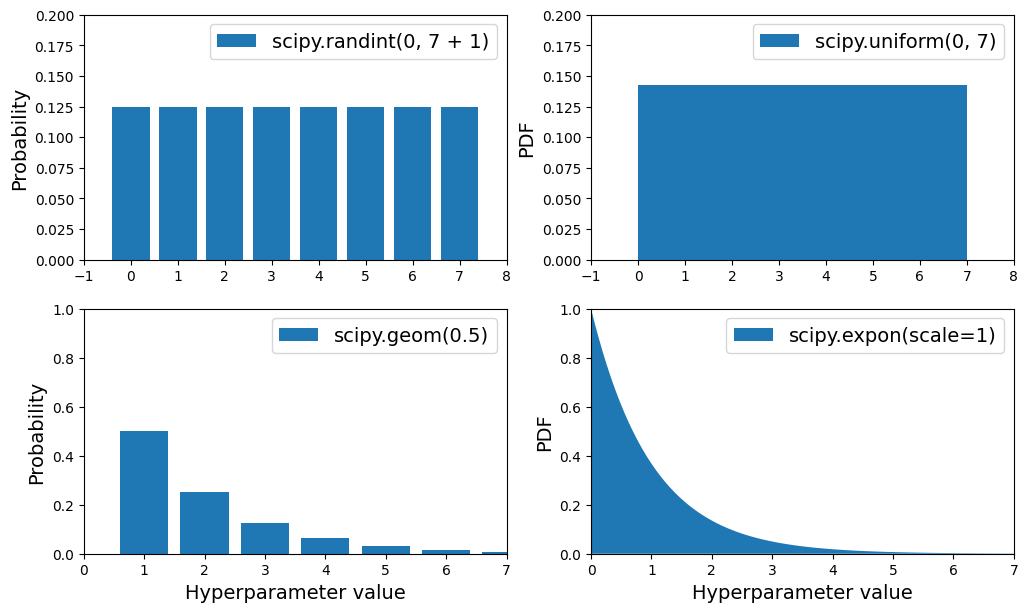

In [105]:
# extra code – plots a few distributions you can use in randomized search

from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

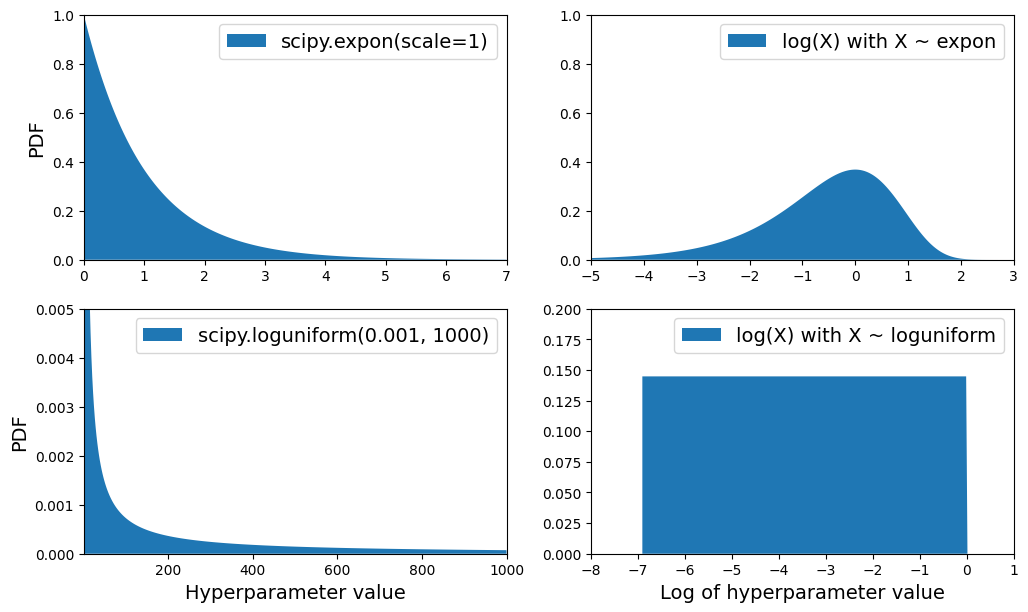

In [106]:
# extra code – shows the difference between expon and loguniform

from scipy.stats import loguniform

xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))

xs3 = np.linspace(0.001, 1000, 500)
loguniform_distrib = loguniform(0.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_loguniform_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib,
                 label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib,
                 label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, loguniform_distrib,
                 label="scipy.loguniform(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_loguniform_distrib,
                 label="log(X) with X ~ loguniform")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])

plt.show()

In [107]:
final_model = rnd_search.best_estimator_

In [108]:
feature_importances = final_model["random_forest"].feature_importances_

In [109]:
feature_importances.round(2)

array([0.02, 0.02, 0.01, 0.02, 0.01, 0.01, 0.01, 0.02, 0.01, 0.03, 0.01,
       0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.03, 0.01, 0.01, 0.02, 0.01, 0.04, 0.01, 0.02,
       0.01, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.24, 0.  , 0.05,
       0.  , 0.  , 0.  ])

In [110]:
sorted(zip(feature_importances, final_model["preprocessing"].get_feature_names_out()))

[(np.float64(7.677974963214034e-05), 'cat__ocean_proximity_ISLAND'),
 (np.float64(0.00029512390626687876), 'cat__ocean_proximity_NEAR BAY'),
 (np.float64(0.0024183981133080357), 'cat__ocean_proximity_NEAR OCEAN'),
 (np.float64(0.003885755511415726), 'geo__Cluster 21 similarity'),
 (np.float64(0.004419359212292582), 'cat__ocean_proximity_<1H OCEAN'),
 (np.float64(0.005308172428601584), 'geo__Cluster 17 similarity'),
 (np.float64(0.005382878773863312), 'geo__Cluster 42 similarity'),
 (np.float64(0.0054141829299558485), 'geo__Cluster 5 similarity'),
 (np.float64(0.005893548582058943), 'geo__Cluster 11 similarity'),
 (np.float64(0.006621307650161808), 'geo__Cluster 38 similarity'),
 (np.float64(0.0073785506523581035), 'geo__Cluster 15 similarity'),
 (np.float64(0.007642681638514274), 'geo__Cluster 4 similarity'),
 (np.float64(0.007696285267142811), 'geo__Cluster 33 similarity'),
 (np.float64(0.00812121625546563), 'geo__Cluster 29 similarity'),
 (np.float64(0.008294812911882258), 'geo__Clus

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(mse)

print(final_rmse)

43194.408122517685


In [120]:
from scipy.stats import bootstrap

def rmse(squared_errors):
    return np.sqrt(np.mean(squared_errors))

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
boot_result = bootstrap([squared_errors], rmse, confidence_level=confidence,
                        random_state=42)
rmse_lower, rmse_upper = boot_result.confidence_interval

In [121]:
print(f"95% CI for RMSE: ({rmse_lower:.4f}, {rmse_upper:.4f})")

95% CI for RMSE: (41186.3515, 45535.2167)


In [122]:
import joblib

joblib.dump(final_model, "housing-cup.ipynb")

['housing-cup.ipynb']

In [230]:
import joblib

# extra code – excluded for conciseness
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("housing-cup.ipynb")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

In [231]:
predictions

array([437354.11, 448725.06, 106275.  , 100554.  , 335956.03])

In [232]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [
        {'svr__kernel': ['linear'], 'svr__C': [10., 30., 100., 300., 1000.,
                                               3000., 10000., 30000.0]},
        {'svr__kernel': ['rbf'], 'svr__C': [1.0, 3.0, 10., 30., 100., 300.,
                                            1000.0],
         'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svr_pipeline = Pipeline([("preprocessing", preprocessing), ("svr", SVR())])
grid_search = GridSearchCV(svr_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

,estimator,"Pipeline(step...svr', SVR())])"
,param_grid,"[{'svr__C': [10.0, 30.0, ...], 'svr__kernel': ['linear']}, {'svr__C': [1.0, 3.0, ...], 'svr__gamma': [0.01, 0.03, ...], 'svr__kernel': ['rbf']}]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...)]"


In [233]:
svr_grid_search_rmse = -grid_search.best_score_
svr_grid_search_rmse

np.float64(69468.85563387202)

In [234]:
grid_search.best_params_

{'svr__C': 30000.0, 'svr__kernel': 'linear'}

In [235]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, loguniform

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `loguniform()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'svr__kernel': ['linear', 'rbf'],
        'svr__C': loguniform(20, 200_000),
        'svr__gamma': expon(scale=1.0),
    }

rnd_search = RandomizedSearchCV(svr_pipeline,
                                param_distributions=param_distribs,
                                n_iter=50, cv=3,
                                scoring='neg_root_mean_squared_error',
                                random_state=42)
rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

,estimator,"Pipeline(step...svr', SVR())])"
,param_distributions,"{'svr__C': <scipy.stats....t 0x115cf0380>, 'svr__gamma': <scipy.stats....t 0x119a57250>, 'svr__kernel': ['linear', 'rbf']}"
,n_iter,50
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [236]:
svr_rnd_search_rmse = -rnd_search.best_score_
svr_rnd_search_rmse

np.float64(57329.265107070365)

In [237]:
rnd_search.best_params_

{'svr__C': np.float64(157055.10989448498),
 'svr__gamma': np.float64(0.26497040005002437),
 'svr__kernel': 'rbf'}

In [238]:
s = expon(scale=1).rvs(100_000, random_state=42)  # get 100,000 samples
((s > 0.105) & (s < 2.29)).sum() / 100_000

np.float64(0.80066)

In [239]:
from sklearn.feature_selection import SelectFromModel

selector_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('selector', SelectFromModel(RandomForestRegressor(random_state=42),
                                 threshold=0.005)),  # min feature importance
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"])),
])

In [241]:
from sklearn.model_selection import cross_val_score

selector_rmses = -cross_val_score(
    selector_pipeline,
    housing.iloc[:5000],
    housing_labels.iloc[:5000],
    scoring="neg_root_mean_squared_error",
    cv=3
)

pd.Series(selector_rmses).describe()

count        3.000000
mean     57377.047054
std       1020.212848
min      56199.646170
25%      57065.891892
50%      57932.137615
75%      57965.747496
max      57999.357376
dtype: float64

In [242]:
from sklearn.base import MetaEstimatorMixin, clone

class FeatureFromRegressor(BaseEstimator, TransformerMixin, MetaEstimatorMixin):
    def __init__(self, regressor, target_features):
        self.regressor = regressor
        self.target_features = target_features

    def fit(self, X, y=None):
        if hasattr(X, "columns"):
            self.feature_names_in_ = list(X.columns)
            X_df = X
        else:
            X_df = pd.DataFrame(X)
        
        self.input_features_ = [c for c in X_df.columns
                                if c not in self.target_features]
        self.regressor_ = clone(self.regressor)
        self.regressor_.fit(X_df[self.input_features_],
                            X_df[self.target_features])
        return self

    def transform(self, X):
        columns = X.columns if hasattr(X, "columns") else None
        X_df = pd.DataFrame(X, columns=columns)
        preds = self.regressor_.predict(X_df[self.input_features_])
        if preds.ndim == 1:
            preds = preds.reshape(-1, 1)
        extra_columns = [f"pred_{t}" for t in self.target_features]
        preds_df = pd.DataFrame(preds, columns=extra_columns, index=X_df.index)
        return pd.concat([X_df, preds_df], axis=1)
    
    def get_feature_names_out(self, input_features=None):
        extra_columns = [f"pred_{t}" for t in self.target_features]
        return self.feature_names_in_ + extra_columns

In [243]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors=3, weights="distance")
knn_transformer = FeatureFromRegressor(knn_reg, ["median_income"])
geo_features = housing[["latitude", "longitude", "median_income"]]
knn_transformer.fit_transform(geo_features, housing_labels)

,latitude,longitude,median_income,pred_median_income
13096,37.80,-122.42,2.0987,3.985767
14973,34.14,-118.38,6.0876,6.899400
3785,38.36,-121.98,2.4330,2.900900
14689,33.75,-117.11,2.2618,2.261800
20507,33.77,-118.15,3.5292,3.475633
...,...,...,...,...
14207,33.86,-118.40,4.7105,4.939100
13105,36.32,-119.31,2.5733,3.301550
19301,32.59,-117.06,4.0616,4.061600
19121,34.06,-118.40,4.1455,4.145500


In [244]:
knn_transformer.get_feature_names_out()

['latitude', 'longitude', 'median_income', 'pred_median_income']

In [246]:
from sklearn.base import clone
from sklearn.compose import ColumnTransformer

# Transformer kopieren
transformers = [(name, clone(transformer), columns)
                for name, transformer, columns in preprocessing.transformers]

# Liste der Namen holen
names = [name for name, _, _ in transformers]

# Prüfen ob "geo" existiert
if "geo" in names:
    geo_index = names.index("geo")
    transformers[geo_index] = (
        "geo",
        knn_transformer,
        ["latitude", "longitude", "median_income"]
    )
else:
    transformers.append((
        "geo",
        knn_transformer,
        ["latitude", "longitude", "median_income"]
    ))

# Neuer ColumnTransformer
new_geo_preprocessing = ColumnTransformer(transformers)

In [247]:
new_geo_pipeline = Pipeline([
    ('preprocessing', new_geo_preprocessing),
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"])),
])

In [248]:
new_pipe_rmses = -cross_val_score(new_geo_pipeline,
                                  housing.iloc[:5000],
                                  housing_labels.iloc[:5000],
                                  scoring="neg_root_mean_squared_error",
                                  cv=3)
pd.Series(new_pipe_rmses).describe()

count        3.000000
mean     66527.251245
std       2429.043887
min      63982.958467
25%      65380.006627
50%      66777.054786
75%      67799.397635
max      68821.740483
dtype: float64

In [249]:
param_distribs = {
    "preprocessing__geo__regressor__n_neighbors": range(1, 30),
    "preprocessing__geo__regressor__weights": ["distance", "uniform"],
    "svr__C": loguniform(20, 200_000),
    "svr__gamma": expon(scale=1.0),
}

new_geo_rnd_search = RandomizedSearchCV(new_geo_pipeline,
                                        param_distributions=param_distribs,
                                        n_iter=50,
                                        cv=3,
                                        scoring='neg_root_mean_squared_error',
                                        random_state=42)
new_geo_rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

,estimator,Pipeline(step...005002437)))])
,param_distributions,"{'preprocessing__geo__regressor__n_neighbors': range(1, 30), 'preprocessing__geo__regressor__weights': ['distance', 'uniform'], 'svr__C': <scipy.stats....t 0x119bb6990>, 'svr__gamma': <scipy.stats....t 0x119bed7c0>}"
,n_iter,50
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [250]:
new_geo_rnd_search_rmse = -new_geo_rnd_search.best_score_
new_geo_rnd_search_rmse

np.float64(65837.10107573589)

In [251]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, validate_data

class StandardScalerClone(TransformerMixin, BaseEstimator):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):
        X = validate_data(self, X, ensure_2d=True)
        self.n_features_in_ = X.shape[1]
        if self.with_mean:
            self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0, ddof=0)
        self.scale_[self.scale_ == 0] = 1  # Avoid division by zero
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = validate_data(self, X, ensure_2d=True, reset=False)
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

    def inverse_transform(self, X):
        check_is_fitted(self)
        X = validate_data(self, X, ensure_2d=True, reset=False)
        return X * self.scale_ + self.mean_

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return getattr(self, "feature_names_in_",
                           [f"x{i}" for i in range(self.n_features_in_)])
        else:
            if len(input_features) != self.n_features_in_:
                raise ValueError("Invalid number of features")
            if hasattr(self, "feature_names_in_") and not np.all(
                self.feature_names_in_ == input_features
            ):
                raise ValueError("input_features ≠ feature_names_in_")
            return input_features

In [252]:
from sklearn.utils.estimator_checks import check_estimator

check_estimator(StandardScalerClone())

[{'estimator': StandardScalerClone(),
  'check_name': 'check_estimator_cloneable',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': StandardScalerClone(),
  'check_name': 'check_estimator_cloneable',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': StandardScalerClone(),
  'check_name': 'check_estimator_tags_renamed',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': StandardScalerClone(),
  'check_name': 'check_valid_tag_types',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': StandardScalerClone(),
  'check_name': 'check_estimator_repr',
  'exception': None,
  'status': 'passed',
  'expec

In [253]:
rng = np.random.default_rng(seed=42)
X = rng.random((1000, 3))

scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(X)

assert np.allclose(X_scaled, (X - X.mean(axis=0)) / X.std(axis=0))

In [254]:
scaler = StandardScalerClone(with_mean=False)
X_scaled_uncentered = scaler.fit_transform(X)

assert np.allclose(X_scaled_uncentered, X / X.std(axis=0))

In [258]:
scaler = StandardScalerClone()
X_back = scaler.inverse_transform(scaler.fit_transform(X))

assert np.allclose(X, X_back)

In [256]:
assert np.all(scaler.get_feature_names_out() == ["x0", "x1", "x2"])
assert np.all(scaler.get_feature_names_out(["a", "b", "c"]) == ["a", "b", "c"])

In [257]:
df = pd.DataFrame({"a": rng.random(100), "b": rng.random(100)})
scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(df)

assert np.all(scaler.feature_names_in_ == ["a", "b"])
assert np.all(scaler.get_feature_names_out() == ["a", "b"])